In [1]:
scriptdirectory = r"C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"
inputdirectory = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_h5"

output_directory = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_paper\new_analysis_02_HCx_GFP_B_hCSF_base"
filename = "02_HCx_GFP_B_hCSF"

temp_dic = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_paper\spike_extraction\02_HCx_GFP_B_hCSF_from_600_to_720_analyzed_on_14102021"

In [2]:
import os
os.chdir(scriptdirectory)

In [3]:
import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd
import pickle

%matplotlib notebook

In [4]:
os.chdir(output_directory)

In [5]:
MAIN_RECORDING_DICTIONARY = pickle.load(open(os.path.join(output_directory+'\\MAIN_RECORDING_Dictionary_'+filename+'.pkl'), "rb"))

In [6]:
MAIN_RECORDING_DICTIONARY.keys()

dict_keys(['spikedic_MAD', 'network_bursts_seconds', 'fr_dic', 'isi_dictionary', 'isi_average_dic', 'Infos_Recording', 'Infos_Analysis', 'Infos_Anatomy', 'Interburst-Intervals', 'bursting_time_per_channel', 'bursts_per_channel', 'burst_connections', 'GRAPH_shared_bursts', 'Basics', 'Bursts'])

In [7]:
network_bursts_seconds = MAIN_RECORDING_DICTIONARY['network_bursts_seconds']
spikedic_MAD = MAIN_RECORDING_DICTIONARY['spikedic_MAD']
fr_dic = MAIN_RECORDING_DICTIONARY['fr_dic']
isi_dictionary = MAIN_RECORDING_DICTIONARY['isi_dictionary']
isi_average_dic = MAIN_RECORDING_DICTIONARY['isi_average_dic']
Infos_Recording = MAIN_RECORDING_DICTIONARY['Infos_Recording']
Infos_Analysis = MAIN_RECORDING_DICTIONARY['Infos_Analysis']
Infos_Anatomy = MAIN_RECORDING_DICTIONARY['Infos_Anatomy']
Bursts = MAIN_RECORDING_DICTIONARY['Bursts']
Interburst_Intervals = MAIN_RECORDING_DICTIONARY['Interburst-Intervals']
bursting_time_per_channel = MAIN_RECORDING_DICTIONARY['bursting_time_per_channel']
bursts_per_channel = MAIN_RECORDING_DICTIONARY['bursts_per_channel']
burst_connections = MAIN_RECORDING_DICTIONARY['burst_connections']
Basics = MAIN_RECORDING_DICTIONARY['Basics']
inverted_layerdic = Infos_Anatomy['layerdic_invert']
layerdic = Infos_Anatomy['layerdic']
tick = 40
scale_factor_for_second = 1e-06

In [8]:
Infos_Recording


{'info_dics_subrecordings': {'0_to_120': {'tick': 40,
   'timelengthrecording_s': 1800.0,
   'first_recording_timepoint': 0,
   'scale_factor_for_second': 1e-06,
   'network_burst_threshold_basline': 431.65977114692873},
  '1080_to_1200': {'tick': 40,
   'timelengthrecording_s': 1800.0,
   'first_recording_timepoint': 0,
   'scale_factor_for_second': 1e-06,
   'network_burst_threshold_basline': 534.0496683643315},
  '1200_to_1320': {'tick': 40,
   'timelengthrecording_s': 1800.0,
   'first_recording_timepoint': 0,
   'scale_factor_for_second': 1e-06,
   'network_burst_threshold_basline': 509.54410311594637},
  '120_to_240': {'tick': 40,
   'timelengthrecording_s': 1800.0,
   'first_recording_timepoint': 0,
   'scale_factor_for_second': 1e-06,
   'network_burst_threshold_basline': 381.58164333698005},
  '1320_to_1440': {'tick': 40,
   'timelengthrecording_s': 1800.0,
   'first_recording_timepoint': 0,
   'scale_factor_for_second': 1e-06,
   'network_burst_threshold_basline': 513.1696488

In [9]:
os.chdir(inputdirectory)

### Import of all Custom Functions

In [10]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



def subdivide_spiketrain(spiketrain, sub_start = 0, sub_stop = 10, tick=40, scale_factor_for_second=1e-06):
    '''
    Excpects: 
        a spiketrain with tick datapoints
        default ticks are 40
        default scale_factor_for_seconds = 1e-06
        provide the start and stop of the desired sub in seconds
    
    Does:
        converts the desired seconds into data ticks
        checks if the spikes of the given spiketrain is in the desired subs
        substracts the starting time -->
        
    Returns:
        a spiketrain dictionary that again starts from zero
    
    '''
    sub_start_tick = sub_start / (tick*scale_factor_for_second)
    sub_stop_tick = sub_stop / (tick*scale_factor_for_second)
    sub_spiketrain = {}
  
    for key in spiketrain: 
        list_per_key = []
        for i in spiketrain[key]:
            if (i>=sub_start_tick ) & (i<sub_stop_tick):
                list_per_key.append(int(i-sub_start_tick))
        sub_spiketrain[key]=list_per_key

    return sub_spiketrain

### Find channels that are bursting during network bursts


In [11]:
Bursts['R12'][-1] #µseconds

(1796679320, 1796740000)

In [12]:
spikedic_MAD['R12'][-1] #ticks

44990937

In [13]:
network_bursts_seconds[-1] #seconds

(1788.88, 1789.71)

In [14]:
tick = 40

In [15]:
length = []

for i in network_bursts_seconds:
    diff = i[1] - i[0]
    length.append(diff)

In [16]:
np.max(length)

4.165000000000006

In [17]:
len(network_bursts_seconds)

462

In [18]:
np.mean(length), np.std(length), np.median(length)

(0.5140692640692665, 0.37943239045372995, 0.49500000000000455)

We want to find every channel that does burst during a network burst. Further, we need for every network burst the amount of active channels (via Spikedic_MAD). The LFP will be extracted in a later step. For this, we will need the raw data.

In [19]:
def find_network_burst_components(network_bursts_seconds, Bursts, spikedic_MAD):
    
    '''
    ______________________
    parameters
    
    network_bursts_seconds : list of tuples
        tuples are all filtered network bursts (i.e., the gaussian smoothed firing rate that
        crosses the mean of the smoothed firing rate)
        
        tuple(a, b) with a = burststart, b = burststop in seconds
        
    
    Bursts : dict
        key = channellabel
        value = list of tuples (a, b) with a = burststart, b = burststop in µseconds
        
    spikedic_MAD : dict
    
        key = channellabel
        value = list of spikes in ticks --> times tick and scale_factor_second_to_receive
            the spikes in seconds
            
    _______________________
    returns
        
    network_bursts_dictionary : dict
        key = tuple (a, b) with a = networkburststart, b = networkburststop in seconds
        
        value = tuple (a,b,c) with a=the number of single channel bursting channels,
                b = the number of active (i.e., spiking) channels, and c = array of all 
                single channel bursting channels
                
    relevant_relevant_channels : list
    
        list with all channels that are active at any network burst
        can be used to filter the original signal when extracting the LFP
    
    
    '''





    network_bursts_dictionary = {}

    # relevant channels is basically all channels that burst at any time in one list
    relevant_channels = []

    for i in network_bursts_seconds:
        network_key = str(i)
        burst_list = []


        bursting_channels = []
        active_channels = []
        for key in Bursts:
            for b in Bursts[key]:
                # if either start or end of single channel burst is within the network burst
                burst_start = b[0]*1e-06
                burst_stop = b[1]*1e-06

                if (i[0] <= burst_start <= i[1]) or (i[0] <= burst_stop <= i[1]):
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    break

        for key in spikedic_MAD:
            for s in spikedic_MAD[key]:
                s = s*tick*1e-06
                if (i[0] <= s <= i[1]):
                    active_channels.append(key)
                    break




        bursting_channels = np.unique(bursting_channels)
        n_bursting_channels = len(bursting_channels)
        active_channels = np.unique(active_channels)
        n_active_channels = len(active_channels)

        network_bursts_dictionary[network_key] = (
            n_bursting_channels, n_active_channels, bursting_channels, active_channels
            )
    
    return network_bursts_dictionary, relevant_channels
        
    

In [20]:
network_bursts_dictionary, relevant_channels = find_network_burst_components(
                                                network_bursts_seconds, Bursts, spikedic_MAD)

In [21]:
network_bursts_dictionary

{'(1.0, 2.85)': (120,
  181,
  array(['A5', 'A6', 'A8', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'C5', 'C6',
         'C7', 'C8', 'C9', 'D10', 'D11', 'D13', 'D4', 'D5', 'D6', 'D7',
         'D8', 'D9', 'E10', 'E11', 'E12', 'E15', 'E4', 'E5', 'E6', 'E7',
         'E8', 'E9', 'F10', 'F11', 'F12', 'F13', 'F5', 'F6', 'F7', 'F8',
         'F9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G16', 'G5', 'G6', 'G7',
         'G8', 'G9', 'H10', 'H11', 'H12', 'H13', 'H16', 'H5', 'H6', 'H8',
         'H9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I7', 'I8',
         'I9', 'K10', 'K11', 'K12', 'K13', 'K8', 'K9', 'L10', 'L11', 'L12',
         'L13', 'L14', 'L15', 'L8', 'L9', 'M10', 'M11', 'M12', 'M13', 'M14',
         'M15', 'M16', 'M8', 'M9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15',
         'N16', 'N8', 'N9', 'O11', 'O12', 'O14', 'O15', 'O16', 'O7', 'O8',
         'O9', 'P11', 'P12', 'P13', 'P14', 'P16', 'R13', 'R14', 'R15'],
        dtype='<U3'),
  array(['A10', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'B

In [22]:
network_bursts_seconds

[(5.84, 6.675),
 (6.71, 6.875),
 (22.005, 22.885),
 (91.93, 92.205),
 (137.235, 137.745),
 (226.35500000000002, 227.88),
 (242.125, 242.805),
 (262.3, 262.84000000000003),
 (277.725, 277.99),
 (372.05, 373.345),
 (391.685, 391.825),
 (434.07, 434.69),
 (509.33500000000004, 527.26),
 (527.82, 531.815),
 (532.015, 532.41),
 (532.64, 532.665),
 (536.565, 537.395),
 (542.795, 543.535),
 (545.41, 546.285),
 (558.585, 559.41),
 (572.3000000000001, 573.57),
 (585.12, 585.29),
 (585.34, 585.44),
 (593.76, 595.645),
 (603.25, 603.315),
 (606.96, 609.25),
 (612.575, 612.6750000000001),
 (615.83, 616.03),
 (616.0500000000001, 616.065),
 (619.415, 619.975),
 (622.835, 623.025),
 (623.205, 623.6800000000001),
 (626.32, 627.335),
 (629.645, 629.99),
 (630.0550000000001, 630.75),
 (636.9350000000001, 638.1),
 (640.57, 641.1750000000001),
 (641.445, 642.525),
 (645.96, 646.02),
 (646.04, 646.0500000000001),
 (648.515, 649.44),
 (654.87, 656.575),
 (656.945, 658.27),
 (659.335, 660.36),
 (660.97, 662.6

In [22]:
os.chdir(temp_dic)

In [23]:
# bandpass and lowpass signal
lowpass_dic = np.load(filename+".h5_600_720_lowpass_signal.npy", allow_pickle=True).item()
bandpass_dic = np.load(filename+".h5_600_720_bandpass_signal.npy", allow_pickle=True).item()

# lfp deviations
lfp_downs = np.load(filename+".h5_600_720_LFP_DOWNS.npy", allow_pickle=True).item()
lfp_ups = np.load(filename+".h5_600_720_LFP_UPS.npy", allow_pickle=True).item()

# lfp amplitudes
lfp_amplit_donws = np.load(filename+".h5_600_720_LFP_Amplitudes_DOWNS.npy", allow_pickle=True).item()
lfp_amplit_ups = np.load(filename+".h5_600_720_LFP_Amplitudes_UPS.npy", allow_pickle=True).item()

In [24]:
lfp_ups

{'R12': [],
 'L10': [],
 'O10': [],
 'P11': [],
 'L9': [],
 'N9': [],
 'M8': [(687.50528, 687.57256)],
 'R8': [],
 'O6': [],
 'N7': [],
 'R4': [],
 'P5': [],
 'R2': [],
 'M5': [],
 'K6': [],
 'I8': [],
 'L2': [],
 'M1': [],
 'I4': [],
 'K3': [],
 'H1': [],
 'I6': [],
 'G4': [],
 'H5': [],
 'E2': [],
 'F3': [],
 'N13': [],
 'O14': [],
 'R13': [],
 'L11': [],
 'O11': [],
 'P12': [],
 'M9': [],
 'N10': [],
 'L8': [],
 'R9': [],
 'O7': [],
 'N8': [],
 'R5': [],
 'P6': [],
 'K7': [],
 'L7': [],
 'N4': [],
 'O3': [],
 'N1': [],
 'L6': [],
 'L3': [],
 'M2': [],
 'I5': [],
 'K4': [],
 'H6': [],
 'I1': [],
 'G3': [],
 'H4': [],
 'E1': [],
 'F2': [],
 'K13': [],
 'L16': [],
 'I12': [],
 'K15': [],
 'I16': [],
 'I14': [],
 'K10': [],
 'O16': [],
 'R14': [],
 'R15': [],
 'O12': [],
 'P13': [],
 'M10': [],
 'N11': [],
 'P9': [],
 'R10': [],
 'O8': [],
 'K8': [],
 'R6': [],
 'P7': [],
 'N5': [],
 'M6': [],
 'P3': [],
 'O4': [],
 'O1': [],
 'P1': [],
 'M3': [],
 'N2': [],
 'K5': [],
 'L4': [],
 'I2':

In [25]:
spikedic_MAD

{'R12': [3397,
  10247,
  11961,
  16154,
  19497,
  25268,
  31876,
  37046,
  38075,
  42898,
  48500,
  62104,
  69936,
  73899,
  87502,
  91573,
  100056,
  105449,
  110584,
  119108,
  127454,
  148769,
  153151,
  160552,
  160596,
  166161,
  171188,
  178860,
  180257,
  183235,
  184912,
  190315,
  190364,
  197381,
  200799,
  205968,
  206617,
  208724,
  213055,
  219901,
  224375,
  224637,
  224684,
  234140,
  240692,
  245687,
  250246,
  258300,
  266067,
  267358,
  270206,
  275167,
  283973,
  290227,
  295760,
  300951,
  309400,
  314733,
  320004,
  324494,
  325544,
  331787,
  340380,
  341803,
  355716,
  359869,
  365976,
  372083,
  378505,
  378553,
  383729,
  391914,
  397067,
  398496,
  399679,
  400773,
  405470,
  409579,
  410195,
  413193,
  418855,
  425903,
  429435,
  431578,
  437199,
  448956,
  453249,
  455570,
  461547,
  470761,
  478847,
  483806,
  489492,
  494180,
  497561,
  499533,
  511362,
  511530,
  517614,
  526983,
  536435,


In [26]:
start, stop = 600, 720

In [256]:
channel_look = 'K16'

In [257]:
second_cut = lowpass_dic[channel_look].shape[0]

In [258]:
lowpass_sig = lowpass_dic[channel_look]
bandpass_sig = bandpass_dic[channel_look]
down_cross = lfp_downs[channel_look]
up_cross = lfp_ups[channel_look]
spikes = spikedic_MAD[channel_look]
channel_bursts = Bursts[channel_look]

In [259]:
up_cross

[(608.56484, 608.72436)]

In [260]:
# scale helper functions to get the right unit
scale_to_sec = lambda x: x*tick*scale_factor_for_second
scaleburst_to_sec = lambda x: x*scale_factor_for_second
scale_to_ticks = lambda x: x/ (tick*scale_factor_for_second)

In [261]:
spikes = list(map(scale_to_sec, spikes))

# cut spikes for the observed part
spikes = [x for x in spikes if start <= x <= stop]

In [262]:
channel_bursts

[(5760, 64120),
 (201360, 5438320),
 (30292480, 30347960),
 (33103040, 33167600),
 (38109840, 38201400),
 (54331240, 54387040),
 (62539920, 62651240),
 (64874320, 65151400),
 (65328200, 69912280),
 (129182120, 129382960),
 (143951520, 143989720),
 (171635920, 171687880),
 (194687480, 194746800),
 (205038800, 205049360),
 (211707640, 211750120),
 (211848640, 211877080),
 (265162800, 265273240),
 (273414640, 273551680),
 (348930320, 349043960),
 (401871400, 401929640),
 (415833280, 416290680),
 (417591520, 417634640),
 (428380480, 428527200),
 (432532920, 432575000),
 (499873720, 499961840),
 (608355240, 608660600),
 (620082680, 620122360),
 (623957760, 624298480),
 (665339920, 665367040),
 (675464720, 675889400),
 (695604720, 696171160),
 (722985080, 723367040),
 (749762560, 750147840),
 (750396320, 750427240),
 (767633960, 767684040),
 (789634400, 789705800),
 (816428000, 816830960),
 (816893320, 816903440),
 (822625120, 822738000),
 (830625960, 830957760),
 (851440320, 851598520),
 (8

In [263]:
#channel_bursts = list(map(scale_to_sec, channel_bursts))
channel_bursts_sec = []
for i in channel_bursts:
    first = scaleburst_to_sec(i[0])
    second = scaleburst_to_sec(i[1])
    new = (first, second)
    channel_bursts_sec.append(new)

In [264]:
channel_bursts_sec

[(0.0057599999999999995, 0.06412),
 (0.20135999999999998, 5.43832),
 (30.292479999999998, 30.347959999999997),
 (33.10304, 33.1676),
 (38.10984, 38.2014),
 (54.33124, 54.38704),
 (62.539919999999995, 62.651239999999994),
 (64.87432, 65.1514),
 (65.3282, 69.91228),
 (129.18212, 129.38296),
 (143.95152, 143.98972),
 (171.63592, 171.68787999999998),
 (194.68748, 194.74679999999998),
 (205.03879999999998, 205.04935999999998),
 (211.70764, 211.75011999999998),
 (211.84864, 211.87707999999998),
 (265.1628, 265.27324),
 (273.41463999999996, 273.55168),
 (348.93032, 349.04395999999997),
 (401.8714, 401.92964),
 (415.83328, 416.29068),
 (417.59152, 417.63464),
 (428.38048, 428.5272),
 (432.53292, 432.575),
 (499.87372, 499.96184),
 (608.35524, 608.6605999999999),
 (620.08268, 620.12236),
 (623.95776, 624.2984799999999),
 (665.33992, 665.36704),
 (675.4647199999999, 675.8894),
 (695.6047199999999, 696.17116),
 (722.9850799999999, 723.36704),
 (749.76256, 750.14784),
 (750.39632, 750.42724),
 (76

In [265]:
# to cut the low pass signal
networkburst_tick = list(map(scale_to_ticks, network_bursts_seconds[0]))
networkburst_tick_start, netwokrburst_tick_stop = int(networkburst_tick[0]), int(networkburst_tick[1])

In [266]:
# cut the low pass signal
network_burst_lowpass_cut = lowpass_sig[networkburst_tick_start:netwokrburst_tick_stop]

In [267]:
# to cut the bursts and networkbursts

cut_network_bursts_seconds = list(filter(lambda x: start < x[0] < stop, network_bursts_seconds))
cut_channel_bursts_seconds = list(filter(lambda x: start < x[0] < stop, channel_bursts_sec))

In [268]:

for networkburst in network_bursts_seconds:
    networkburst_tick = list(map(scale_to_ticks, networkburst))
    networkburst_tick_start, netwokrburst_tick_stop = int(networkburst_tick[0]), int(networkburst_tick[1])
    network_burst_lowpass_cut = lowpass_sig[networkburst_tick_start:netwokrburst_tick_stop]
                             
    mean_lowpass_cut = np.mean(network_burst_lowpass_cut)
    std_lowpass_cut = np.std(network_burst_lowpass_cut)
    
    print('Channel {}, at {}, mean: {} with std {}'.format(
        channel_look, networkburst, mean_lowpass_cut, std_lowpass_cut ))

mean_channel = np.mean(lowpass_sig)
std_channel = np.std(lowpass_sig)
print('Channel {} total, mean: {} with std {}'.format(
        channel_look, mean_channel, std_channel))
    

Channel K16, at (1.0, 2.85), mean: -0.20693190420496504 with std 0.9767294979674531
Channel K16, at (3.1550000000000002, 4.385), mean: -0.21797957926070335 with std 1.0055159819027288
Channel K16, at (41.9, 42.62), mean: -0.27675558093776503 with std 0.9765175166101281
Channel K16, at (44.465, 44.93), mean: 0.059379514726718485 with std 0.9504177466363614
Channel K16, at (54.785000000000004, 55.585), mean: -0.3032291389903123 with std 1.3056722100621196
Channel K16, at (56.01, 56.77), mean: 0.0541160104506556 with std 0.9414307699504718
Channel K16, at (64.175, 68.34), mean: -0.3139869115189345 with std 1.1281837865600162
Channel K16, at (111.77, 112.69500000000001), mean: -0.4887117781260219 with std 0.9773206853351
Channel K16, at (113.68, 113.87), mean: -0.6147681494285004 with std 0.8521708731324237
Channel K16, at (114.57000000000001, 114.715), mean: 0.7168610012584763 with std 0.8604761958189885
Channel K16, at (115.03, 115.355), mean: -0.5276538614870989 with std 1.3712064774375

C:\Users\User\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\User\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [269]:
len(lowpass_sig)

3000001

In [270]:
tick_micro = 0.00004
time_in_sec = np.arange(start, stop+tick_micro, tick_micro)

In [271]:
len(time_in_sec)

3000001

In [272]:
network_bursts_seconds

[(1.0, 2.85),
 (3.1550000000000002, 4.385),
 (41.9, 42.62),
 (44.465, 44.93),
 (54.785000000000004, 55.585),
 (56.01, 56.77),
 (64.175, 68.34),
 (111.77, 112.69500000000001),
 (113.68, 113.87),
 (114.57000000000001, 114.715),
 (115.03, 115.355),
 (123.34, 124.07000000000001),
 (124.965, 125.63000000000001),
 (126.735, 127.03),
 (159.535, 160.38),
 (161.035, 161.595),
 (162.615, 162.94),
 (205.63, 206.16),
 (206.915, 207.275),
 (220.53, 221.425),
 (222.63, 223.065),
 (265.98, 266.84000000000003),
 (267.735, 268.295),
 (287.49, 288.445),
 (290.42, 291.25),
 (294.93, 295.735),
 (296.595, 297.09000000000003),
 (312.26, 312.865),
 (313.89, 313.975),
 (321.135, 321.82),
 (328.685, 329.28000000000003),
 (330.87, 331.64),
 (333.185, 333.99),
 (338.5, 339.145),
 (342.415, 343.17),
 (344.09000000000003, 344.63),
 (349.2, 349.855),
 (361.845, 362.53000000000003),
 (363.8, 364.12),
 (380.94, 381.805),
 (383.735, 384.705),
 (388.47, 389.225),
 (390.475, 391.18),
 (392.735, 393.19),
 (394.785, 395.5

In [273]:
channel_mean = np.mean(lowpass_sig)
print('Lowpass mean of {} at  {} is '.format(channel_look, networkburst)+str(channel_mean))

Lowpass mean of K16 at  (1788.88, 1789.71) is -0.25049118987547314


In [274]:
np.std(lowpass_sig)

1.1684459878590783

In [275]:
lfp_mean = np.mean(lowpass_sig)

In [276]:
lfp_threshold = 3*np.std(lowpass_sig)

In [277]:
time_in_sec.shape[0] * lfp_threshold

10516017.396069668

In [278]:
threshold_line = np.linspace(lfp_threshold, lfp_threshold, len(time_in_sec))

In [279]:
convolved_signal = np.convolve(lowpass_sig, np.ones(3000)/3000, mode='full')

In [280]:
len(convolved_signal)

3003000

In [281]:
cs = convolved_signal[:3000001]

In [282]:
cs_threshold = np.mean(cs) + np.std(cs)

In [283]:
cs_threshold_line = np.linspace(cs_threshold, cs_threshold, len(time_in_sec))

In [284]:
cs_threshold

0.4752888674523636

<IPython.core.display.Javascript object>


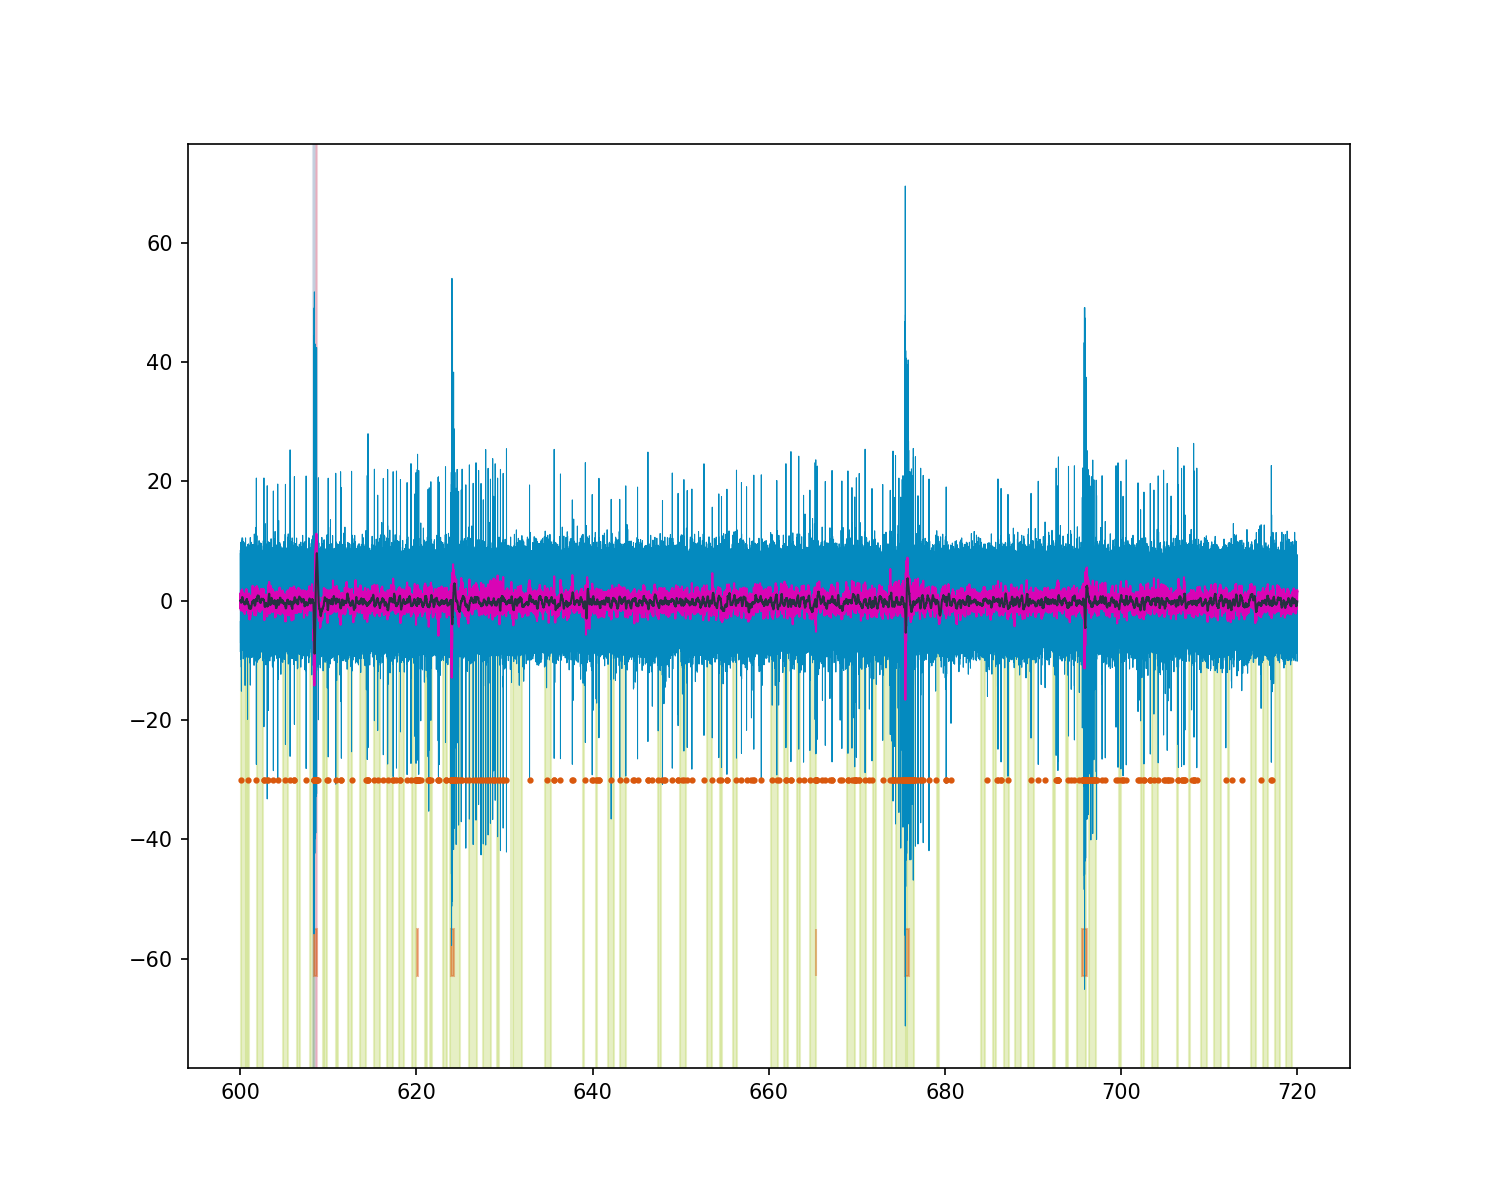

<ipython-input-285-5f6cfd84e520>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(spikes, [-30]*np.asarray(spikes).shape[0], 'ro', ms=2, c="#D9580D")


In [285]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))


ax.plot(time_in_sec[:second_cut], bandpass_sig, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec[:second_cut], lowpass_sig, c = '#D904B5',  linewidth = 1)
ax.plot(spikes, [-30]*np.asarray(spikes).shape[0], 'ro', ms=2, c="#D9580D")
ax.plot(time_in_sec, cs_threshold_line, c = '#D904B5', linewidth = 0.5 )
ax.plot(time_in_sec, -cs_threshold_line, c = '#D904B5', linewidth = 0.5 )
#ax.plot(time_in_sec, -threshold_line, c = '#D904B5', linewidth = 0.5 )
ax.plot(time_in_sec[:second_cut], cs, c = '#263140',  linewidth = 1)

for i in cut_network_bursts_seconds:
    ax = plt.axvspan(i[0], i[1], .0, .5, color= '#C1D96C', alpha = 0.4)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
for i in cut_channel_bursts_seconds:
    ax = plt.axvspan(i[0], i[1], .1, .15, color= '#D9580D', alpha = 0.4)

In [57]:
lfp_ups[channel_look]

[(608.56484, 608.72436)]

In [56]:
Infos_Anatomy = MAIN_RECORDING_DICTIONARY['Infos_Anatomy']


In [144]:
lfp_downs

{'R12': [],
 'L10': [],
 'O10': [],
 'P11': [],
 'L9': [],
 'N9': [],
 'M8': [],
 'R8': [],
 'O6': [(47.28715999999999, 47.33864)],
 'N7': [],
 'R4': [],
 'P5': [(47.275079999999996, 47.33104)],
 'R2': [(47.20192, 47.26012), (47.264799999999994, 47.370839999999994)],
 'M5': [(47.26108, 47.37744)],
 'K6': [],
 'I8': [],
 'L2': [(47.26788, 47.338680000000004)],
 'M1': [(47.202799999999996, 47.34428)],
 'I4': [(20.146639999999998, 20.220439999999996)],
 'K3': [(68.13419999999999, 68.23912)],
 'H1': [(47.273239999999994, 47.36104)],
 'I6': [],
 'G4': [],
 'H5': [],
 'E2': [(9.757719999999999, 9.84112),
  (47.21004, 47.278760000000005),
  (47.28308, 47.35684)],
 'F3': [],
 'N13': [],
 'O14': [],
 'R13': [(47.287, 47.33988)],
 'L11': [],
 'O11': [],
 'P12': [(101.42519999999999, 101.48964)],
 'M9': [],
 'N10': [],
 'L8': [],
 'R9': [],
 'O7': [(45.947559999999996, 45.99764)],
 'N8': [(47.28276, 47.33744)],
 'R5': [],
 'P6': [],
 'K7': [(47.26859999999999, 47.3394)],
 'L7': [],
 'N4': [],
 'O

In [73]:
def find_network_burst_components(network_bursts_seconds, 
                                  Bursts, spikedic_MAD, ups, up_amplitudes, downs, down_amplitudes):
    
    '''
    ______________________
    parameters
    
    network_bursts_seconds : list of tuples
        tuples are all filtered network bursts (i.e., the gaussian smoothed firing rate that
        crosses the mean of the smoothed firing rate)
        
        tuple(a, b) with a = burststart, b = burststop in seconds
        
    
    Bursts : dict
        key = channellabel
        value = list of tuples (a, b) with a = burststart, b = burststop in µseconds
        
    spikedic_MAD : dict
    
        key = channellabel
        value = list of spikes in ticks --> times tick and scale_factor_second_to_receive
            the spikes in seconds
            
    _______________________
    returns
        
    network_bursts_dictionary : dict
        key = tuple (a, b) with a = networkburststart, b = networkburststop in seconds
        
        value = tuple (a,b,c) with a=the number of single channel bursting channels,
                b = the number of active (i.e., spiking) channels, and c = array of all 
                single channel bursting channels
                
    relevant_relevant_channels : list
    
        list with all channels that are active at any network burst
        can be used to filter the original signal when extracting the LFP
    
    
    '''





    
    network_burts_dictionary = {}
    # relevant channels is basically all channels that burst at any time in one list
    relevant_channels = []

    for i in network_bursts_seconds:
        
        network_features_dic = {}
        
        network_key = str(i)
        burst_list = []
        bursting_channels = []
        active_channels = []
        
        # get all channels that burst while the network burst is going on
        total_number_burst_starts = 0
        total_number_burst_ends = 0
        for key in Bursts:   
            for b in Bursts[key]:
                # if either start or end of single channel burst is within the network burst
                burst_start = b[0]*1e-06
                burst_stop = b[1]*1e-06
                   
                    
                # every burst that starts and every burst that stops
                # is counted into the bursting channels and for the
                # total number of bursts
               
                if i[0] <= burst_start <= i[1]:
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    total_number_burst_starts +=1
                    
                    
                if i[0] <= burst_stop <= i[1]:
                    bursting_channels.append(key)
                    relevant_channels.append(key)
                    total_number_burst_ends +=1
        
        # all channels that have a spike
        spikecount = 0
        for key in spikedic_MAD:
            for s in spikedic_MAD[key]:
                s = s*tick*1e-06
                if i[0] <= s <= i[1]:
                    spikecount += 1
                    active_channels.append(key)
                    
                    
        lfp_up_list = []            
        for key in ups:
            for up in ups[key]:
                up_start = up[0]
                up_stop = up[1]

                if (i[0] <= up_start <= i[1]) or (i[0] <= up_stop <= i[1]):
                    lfp_up_list.append(key)
                
        
        # add features to the dictionary
        # bursting channels
        bursting_channels = np.unique(bursting_channels)
        network_features_dic['bursting_channels'] = bursting_channels
        
        # number of bursting channels
        n_bursting_channels = len(bursting_channels)
        network_features_dic['number_of_bursting_channels'] = n_bursting_channels
        
        # number of bursting channels
        network_features_dic['number_burst_starts'] = total_number_burst_starts
        network_features_dic['number_burst_ends'] = total_number_burst_starts
        
        #active channels
        active_channels = np.unique(active_channels)
        network_features_dic['active_channels'] = active_channels
        
        #number of active channels
        n_active_channels = len(active_channels)
        network_features_dic['number_of_active_channels'] = n_active_channels
        
        #total number of spikes 
        network_features_dic['number_of_spikes'] = spikecount
        
        network_bursts_dictionary[network_key] = (network_features_dic)
    
    return network_bursts_dictionary, relevant_channels
        

in die obige Funktion muss folgendes rein, bzw. es muss folgenden gemacht werden:
- jeder Netzwerkburst wird zum key
- als value wird ein dictionary mit folgenden Werten:
- anzahl spikes
- anzahl bursts
- anzahl active channels
- anzahl bursting channels
- anzahl lfp ups
- mean amplitude lfp ups
- anzahl lfp downs
- mean amplitude lfp downs
- length der lfp ups and downs
- spannend auch wieviele der spikes sind burst spikes und wieviel single spikes

###### im DF dazu: 
- anzahl der beteiligten channels pro layer
- ggf. auch prozentual


###### im Anschluss
für jeden Netzworkburst eine Heatmap mit der Ausbreitung
- das alles muss pro recording für die 120 sekunden Untereinheit gemacht werden
- vorteil ist, das geht alles in einen dataframe, ist also nicht schlimm, dass es ggf. nacheinander kommt.


###### ich kann nicht mehr
im dataframe werden damit auch erstmal völlig wertfrei alle quatsch network bursts (also nur 1 channel oder ähnliches) aufgenommen. das ist nicht schlimm, da im Anschluss alles gefiltert werden kann. 

###### Idee für später: 
-das Burst verhalten eines Channels zu charakterisieren (periodisch, sporadisch, anzahl units, layer)

In [74]:
trial, asb = find_network_burst_components(network_bursts_seconds, 
                                  Bursts, spikedic_MAD, lfp_ups, lfp_amplit_ups, lfp_downs, lfp_amplit_donws)

In [75]:
trial

{'(5.84, 6.675)': {'bursting_channels': array(['A6', 'B6', 'B7', 'C7', 'C9', 'D12', 'D4', 'D6', 'E12', 'F5', 'F6',
         'G10', 'G5', 'G6', 'G8', 'H13', 'H14', 'H16', 'H5', 'H8', 'H9',
         'I10', 'I12', 'I14', 'I9', 'K10', 'K12', 'K6', 'K8', 'K9', 'L10',
         'L11', 'L12', 'L16', 'L7', 'L9', 'M1', 'M12', 'M13', 'M14', 'M15',
         'M6', 'M8', 'M9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N6',
         'N7', 'O10', 'O11', 'O12', 'O13', 'O14', 'O15', 'O16', 'O6', 'P11',
         'P13', 'P14', 'P16', 'R12', 'R13', 'R14', 'R8'], dtype='<U3'),
  'number_of_bursting_channels': 68,
  'number_burst_starts': 87,
  'number_burst_ends': 87,
  'active_channels': array([], dtype=float64),
  'number_of_active_channels': 0,
  'number_of_spikes': 0},
 '(6.71, 6.875)': {'bursting_channels': array(['B8', 'C5', 'D4', 'E6', 'E7', 'F12', 'F6', 'G10', 'H16', 'I14',
         'K8', 'L12', 'L16', 'L6', 'M13', 'M15', 'M6', 'M7', 'M8', 'M9',
         'N11', 'N12', 'N13', 'N14', 'N16', 'N7', 'O1

In [126]:
network_bursts_seconds = network_bursts_seconds[:4]

In [128]:
network_bursts_dictionary

{'(5.84, 6.675)': (64,
  143,
  array(['A6', 'B6', 'B7', 'C7', 'C9', 'D12', 'D4', 'D6', 'E12', 'F5', 'F6',
         'G5', 'G6', 'G8', 'H14', 'H16', 'H5', 'H8', 'H9', 'I10', 'I12',
         'I14', 'I9', 'K10', 'K12', 'K6', 'K8', 'K9', 'L10', 'L11', 'L12',
         'L16', 'L7', 'L9', 'M1', 'M12', 'M13', 'M15', 'M6', 'M8', 'M9',
         'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N6', 'N7', 'O10', 'O11',
         'O12', 'O13', 'O14', 'O15', 'O16', 'O6', 'P11', 'P13', 'P14',
         'P16', 'R13', 'R14', 'R8'], dtype='<U3'),
  array(['A3', 'A4', 'A5', 'A6', 'A7', 'B2', 'B3', 'B6', 'B7', 'B8', 'C13',
         'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D12', 'D3', 'D4',
         'D6', 'D7', 'D9', 'E11', 'E12', 'E15', 'E3', 'E4', 'E5', 'E6',
         'E7', 'E8', 'E9', 'F10', 'F3', 'F4', 'F5', 'F6', 'F8', 'G10',
         'G11', 'G12', 'G13', 'G16', 'G4', 'G5', 'G6', 'G8', 'G9', 'H10',
         'H11', 'H13', 'H14', 'H15', 'H16', 'H4', 'H5', 'H6', 'H8', 'H9',
         'I10', 'I11', 'I12', 

In [201]:
active_channels = 0
spikedic_seconds = {}
for key in spikedic_MAD:
    relevant_factor = timelengthrecording_s*0.05
    if len(spikedic_MAD[key])>relevant_factor:
        sec_array = np.asarray(spikedic_MAD[key])*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1
spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  

In [39]:
# set filter cuts in Hz
lowcut = 150
highcut = 4500

# Length of cutouts around shapes
pre = 0.001 # 1 ms
post= 0.002 # 2 ms


# get filelist
os.chdir(inputdirectory)
filelist= glob.glob("*.h5")


resting_spikedic={}
spikedic={}
spikedic_MAD={}
artefactsdic_MAD={}
cutouts_dic ={} 
keylist = []

In [40]:
# choose the file for filtering
filelist

['01_HCx_GFP_B_aCSF_base.h5',
 '02_HCx_GFP_B_hCSF.h5',
 '03_HCx_GFP_B_aCSF_post.h5',
 '04_HCx_GFP_B_aCSF_highK.h5',
 'HCx_GFP_B_aCSF_1000on10soff.h5',
 'HCx_GFP_B_aCSF_10hz_20on80off_60s.h5',
 'HCx_GFP_B_aCSF_10hz_50on50off_60s.h5',
 'HCx_GFP_B_aCSF_20hz_30on20off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_10on10off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_1on19off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_5on15off_1s.h5']

In [41]:
filename = filelist[0]

In [42]:
filedatebase = filename.split('T')[0]
filenamebase = filename.split('.h5')[0]
filebase = filedatebase + '_' + filenamebase
print('Working on file: ' +filename)
channel_raw_data = McsPy.McsData.RawData(filename)
get_channel_infos(inputdirectory, filename)

Working on file: 01_HCx_GFP_B_aCSF_base.h5
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
{0: <Recording label=, AnalogStreams=2, duration_time=-636910129389689992 microsecond>}

2019-04-16 12:05:18.969000
Dienstag, 16. April 2019
636910131189689992
00000000-0000-0000-0000-000000000000
256MEA100/30iR

256MEA100_30_iR
MC_Rack
4.5.3.0
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">
In total 2 analog_streams were identified.


In [43]:
# import of the analogstream with the recording data
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
stream = analog_stream_0
for key in stream.channel_infos.keys():
    keylist.append(key)

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">


In [44]:
analog_stream_0


<AnalogStream label=elec0001, channels=252, samples=45000000>

In [45]:
# we assign all basic info of that recording to parameters

channel_id = keylist[0]
tick = stream.channel_infos[channel_id].info['Tick']
time = stream.get_channel_sample_timestamps(channel_id)
first_recording_timepoint = time[0][0]
scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
time_in_sec = time[0]*scale_factor_for_second
timelengthrecording_ms = time[0][-1]+tick
timelengthrecording_s = (time[0][-1]+tick)*scale_factor_for_second
fs = int(stream.channel_infos[channel_id].sampling_frequency.magnitude)

In [28]:
# import the actual data 

analog_stream_0_data = analog_stream_0.channel_data
np_analog_stream_0_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
    

In [34]:
np_analog_stream_0_data.shape

(45000000, 252)

In [33]:
# the data is now transposed
np_analog_for_filter = np.transpose(np_analog_stream_0_data)
np_analog_stream_1_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
np_analog_stream_1_data_transpose = np.transpose(np_analog_stream_1_data)

In [35]:
np_analog_stream_1_data_transpose.shape

(252, 45000000)

In [36]:
# choose the correct channel you want to plot
labellist = get_MEA_Channel_labels(np_analog_for_filter)

# make a dictionary so we can reverse search
label_number_dic = {}
for i in range(0, len(labellist)):
    channel_label = labellist[i]
    label_number_dic[channel_label] = i

In [37]:
label_number_dic

{'R12': 0,
 'L10': 1,
 'O10': 2,
 'P11': 3,
 'L9': 4,
 'N9': 5,
 'M8': 6,
 'R8': 7,
 'O6': 8,
 'N7': 9,
 'R4': 10,
 'P5': 11,
 'R2': 12,
 'M5': 13,
 'K6': 14,
 'I8': 15,
 'L2': 16,
 'M1': 17,
 'I4': 18,
 'K3': 19,
 'H1': 20,
 'I6': 21,
 'G4': 22,
 'H5': 23,
 'E2': 24,
 'F3': 25,
 'N13': 26,
 'O14': 27,
 'R13': 28,
 'L11': 29,
 'O11': 30,
 'P12': 31,
 'M9': 32,
 'N10': 33,
 'L8': 34,
 'R9': 35,
 'O7': 36,
 'N8': 37,
 'R5': 38,
 'P6': 39,
 'K7': 40,
 'L7': 41,
 'N4': 42,
 'O3': 43,
 'N1': 44,
 'L6': 45,
 'L3': 46,
 'M2': 47,
 'I5': 48,
 'K4': 49,
 'H6': 50,
 'I1': 51,
 'G3': 52,
 'H4': 53,
 'E1': 54,
 'F2': 55,
 'K13': 56,
 'L16': 57,
 'I12': 58,
 'K15': 59,
 'I16': 60,
 'I14': 61,
 'K10': 62,
 'O16': 63,
 'R14': 64,
 'R15': 65,
 'O12': 66,
 'P13': 67,
 'M10': 68,
 'N11': 69,
 'P9': 70,
 'R10': 71,
 'O8': 72,
 'K8': 73,
 'R6': 74,
 'P7': 75,
 'N5': 76,
 'M6': 77,
 'P3': 78,
 'O4': 79,
 'O1': 80,
 'P1': 81,
 'M3': 82,
 'N2': 83,
 'K5': 84,
 'L4': 85,
 'I2': 86,
 'K1': 87,
 'H3': 88,
 'H7'

In [21]:
channel_idx = label_number_dic['F15']
channellabel = labellist[channel_idx]

In [22]:
signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
bandpassfilteredsignal = butter_bandpass_filter(
    signal_in_uV, lowcut, highcut, sampling_frequency
    )

In [ ]:
channel_idx = 0

In [40]:
len(relevant_channels)

12120

In [41]:
relevant_channels = np.unique(relevant_channels)

### for whole dictionary with all bandpass and lowpass filtered signals



In [66]:
print(time.asctime( time.localtime(time.time()) ))

Wed Aug 11 14:14:50 2021


In [ ]:
### cave: hier auf jeden fall die bereits vorhandenen dics einladen, dauert sonst sehr lange das ganze zu laden!

In [ ]:
bandpass_dic={}
lowpass_dic={}

#for i in range (0, len(np_analog_for_filter)):
#for i in range(0, 1):
for c in relevant_channels:
    # for every channel we get the signal, filter it, define a threshold
    # see the crossings, align them to the next minimum (=spikes)
    # fill the dictionary with the tickpoints
    # and finally plot everything
    
    i = label_number_dic[c]
    channel_idx = i
    channellabel = labellist[channel_idx]
    labellist = get_MEA_Channel_labels(np_analog_for_filter)
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, channel_idx)
    bandpassfilteredsignal = butter_bandpass_filter(
        signal_in_uV, lowcut, highcut, sampling_frequency
        )
    
    # get the lowpass signal
    # Filter requirements.
    T = timelengthrecording_s         # Sample Period
    fs = fs      # sample rate, Hz
    cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    
    bandpass_dic[channellabel] = bandpassfilteredsignal
    lowpass_dic[channellabel] = butter_lowpass_filtered_signal
    
    
    


In [ ]:
np.save('lowpass_dic_new.npy', lowpass_dic)
np.save('bandpass_dic_new.npy', bandpass_dic)

In [18]:
lowpassdic = np.load('lowpass_dic_new.npy', allow_pickle=True).item()

FileNotFoundError: [Errno 2] No such file or directory: 'lowpass_dic_new.npy'

In [61]:
os.chdir(inputdirectory)

In [62]:
filelist = glob.glob('*.npy')

In [63]:
filelist

['bandpass_dic_01_HCx_GFP_B_aCSF_base.h5.npy',
 'lowpass_dic_01_HCx_GFP_B_aCSF_base.h5.npy']

In [19]:
lowpass_dic = np.load('lowpass_dic_01_HCx_GFP_B_aCSF_base.h5.npy', allow_pickle=True).item()
bandpass_dic = np.load('bandpass_dic_01_HCx_GFP_B_aCSF_base.h5.npy', allow_pickle=True).item()

In [20]:
lowpass_dic

{'R12': array([-5.40731824, -5.34941796, -5.29153488, ...,  0.69765651,
         0.69771435,  0.69776041]),
 'L10': array([-3.78970613, -3.76204916, -3.73444667, ..., -0.11859162,
        -0.11858233, -0.11856961]),
 'O10': array([ 0.2844296 ,  0.29095122,  0.29752921, ..., 11.64993948,
        11.65002104, 11.65008736]),
 'P11': array([1.86308031, 1.83476298, 1.80649406, ..., 1.810746  , 1.81084812,
        1.81093579]),
 'L9': array([ 4.99649771,  4.96343688,  4.93033768, ..., -0.20928289,
        -0.2092425 , -0.2092059 ]),
 'N9': array([-3.7808846 , -3.73806696, -3.69529163, ...,  1.40756469,
         1.40757694,  1.40758326]),
 'M8': array([-5.13857288, -5.08627538, -5.03395654, ...,  1.10900821,
         1.10904496,  1.10907277]),
 'R8': array([5.78992001, 5.74104326, 5.69217996, ..., 1.22372431, 1.22373107,
        1.22373645]),
 'O6': array([ 0.29611945,  0.29869528,  0.30128464, ..., -0.79511693,
        -0.79497354, -0.7948561 ]),
 'N7': array([ 0.60871318,  0.59216074,  0.57

In [67]:
bandpassfilteredsignal = bandpass_dic['R12']

In [181]:
print(time.asctime( time.localtime(time.time()) ))
os.chdir(outputdirectory)

Wed Aug 11 16:55:29 2021


In [68]:
lowpass_dic

{'R12': array([-5.40731824, -5.34941796, -5.29153488, ...,  0.69765651,
         0.69771435,  0.69776041]),
 'L10': array([-3.78970613, -3.76204916, -3.73444667, ..., -0.11859162,
        -0.11858233, -0.11856961]),
 'O10': array([ 0.2844296 ,  0.29095122,  0.29752921, ..., 11.64993948,
        11.65002104, 11.65008736]),
 'P11': array([1.86308031, 1.83476298, 1.80649406, ..., 1.810746  , 1.81084812,
        1.81093579]),
 'L9': array([ 4.99649771,  4.96343688,  4.93033768, ..., -0.20928289,
        -0.2092425 , -0.2092059 ]),
 'N9': array([-3.7808846 , -3.73806696, -3.69529163, ...,  1.40756469,
         1.40757694,  1.40758326]),
 'M8': array([-5.13857288, -5.08627538, -5.03395654, ...,  1.10900821,
         1.10904496,  1.10907277]),
 'R8': array([5.78992001, 5.74104326, 5.69217996, ..., 1.22372431, 1.22373107,
        1.22373645]),
 'O6': array([ 0.29611945,  0.29869528,  0.30128464, ..., -0.79511693,
        -0.79497354, -0.7948561 ]),
 'N7': array([ 0.60871318,  0.59216074,  0.57

In [69]:
butter_lowpass_filtered_signal = lowpass_dic['R12']

<IPython.core.display.Javascript object>


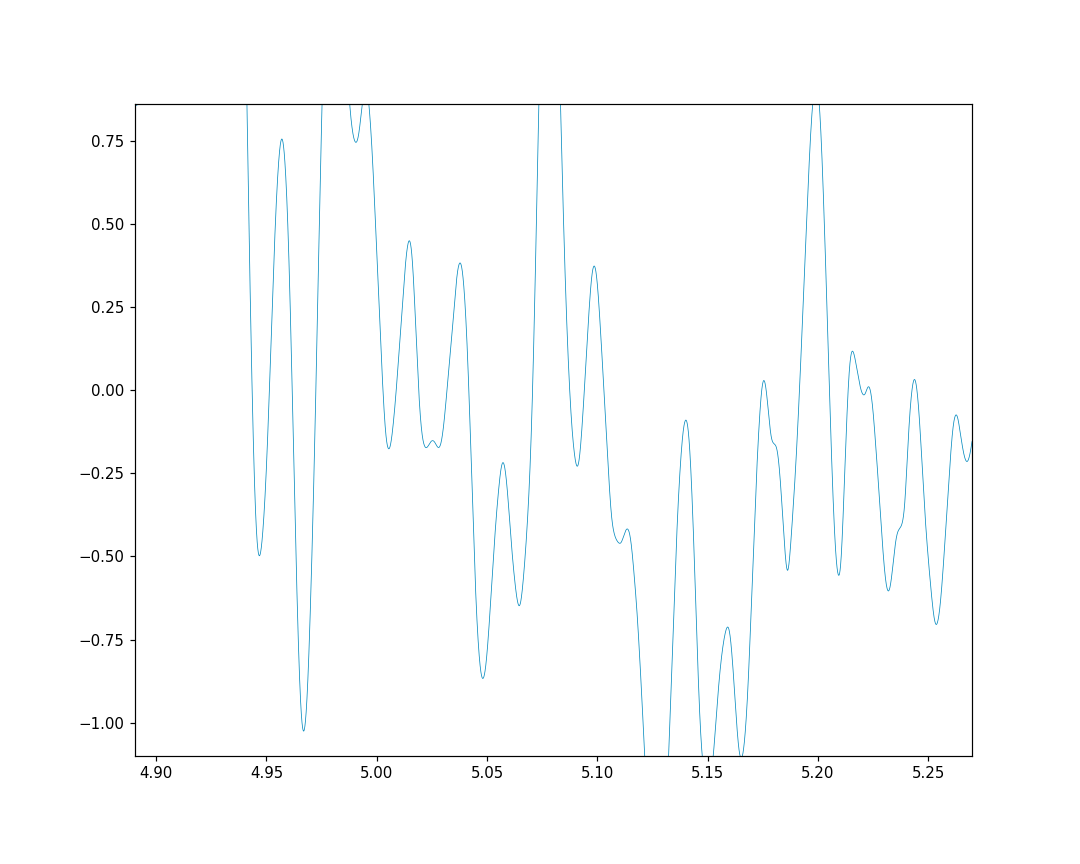

In [75]:
# plot the signal and the filter

fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec[:250001], butter_lowpass_filtered_signal, c = '#048ABF',  linewidth = 0.5)
#ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)

In [74]:
time_in_sec.shape

(45000000,)

In [28]:
# Filter requirements.
T = timelengthrecording_s         # Sample Period
fs = fs      # sample rate, Hz
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [23]:
nyq

12500.0

In [24]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [25]:
butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)

No handles with labels found to put in legend.


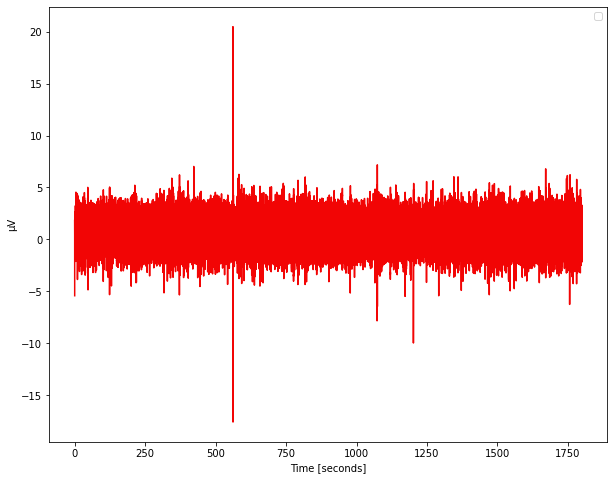

In [32]:
fig, ax = plt.subplots(1, 1, figsize = (12,8))

#ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec, butter_lowpass_filtered_signal, c = '#F20505', linewidth = 1.5)
#ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('µV')
ax.legend()

In [27]:
butter_lowpass_filtered_signal

array([11.37718047, 11.30829344, 11.23937924, ...,  2.20964416,
        2.20994097,  2.21018602])

In [29]:
noise_mad = np.median(np.absolute(bandpassfilteredsignal)) / 0.6745
threshold = -5* noise_mad
artefact_threshold = -8* noise_mad
crossings = detect_threshold_crossings(
    bandpassfilteredsignal, sampling_frequency, 
    threshold, dead_time=0.001
    )
spikes=align_to_minimum(
    bandpassfilteredsignal, fs, crossings, search_range=0.003, 
    first_time_stamp=first_recording_timepoint
    )

In [30]:
spikes

array([1563659, 1563813, 1571219, 1911199, 2181412, 2258293, 2258629,
       2258788, 2259267, 2259367, 2259493, 2259610, 2259762, 2260014,
       2260263, 2262410, 2263298, 2263944, 2264733, 2265672, 2266803,
       2271248, 2271407, 2664734, 2665071, 2665283, 2665420, 2665626,
       2665726, 2665889, 2666044, 2666186, 2666606, 2667118, 2667254,
       2667524, 2668113, 2669111, 2669587, 2670870, 2672165, 2673329,
       2834014, 2834241, 2834367, 2974797], dtype=int64)

<IPython.core.display.Javascript object>


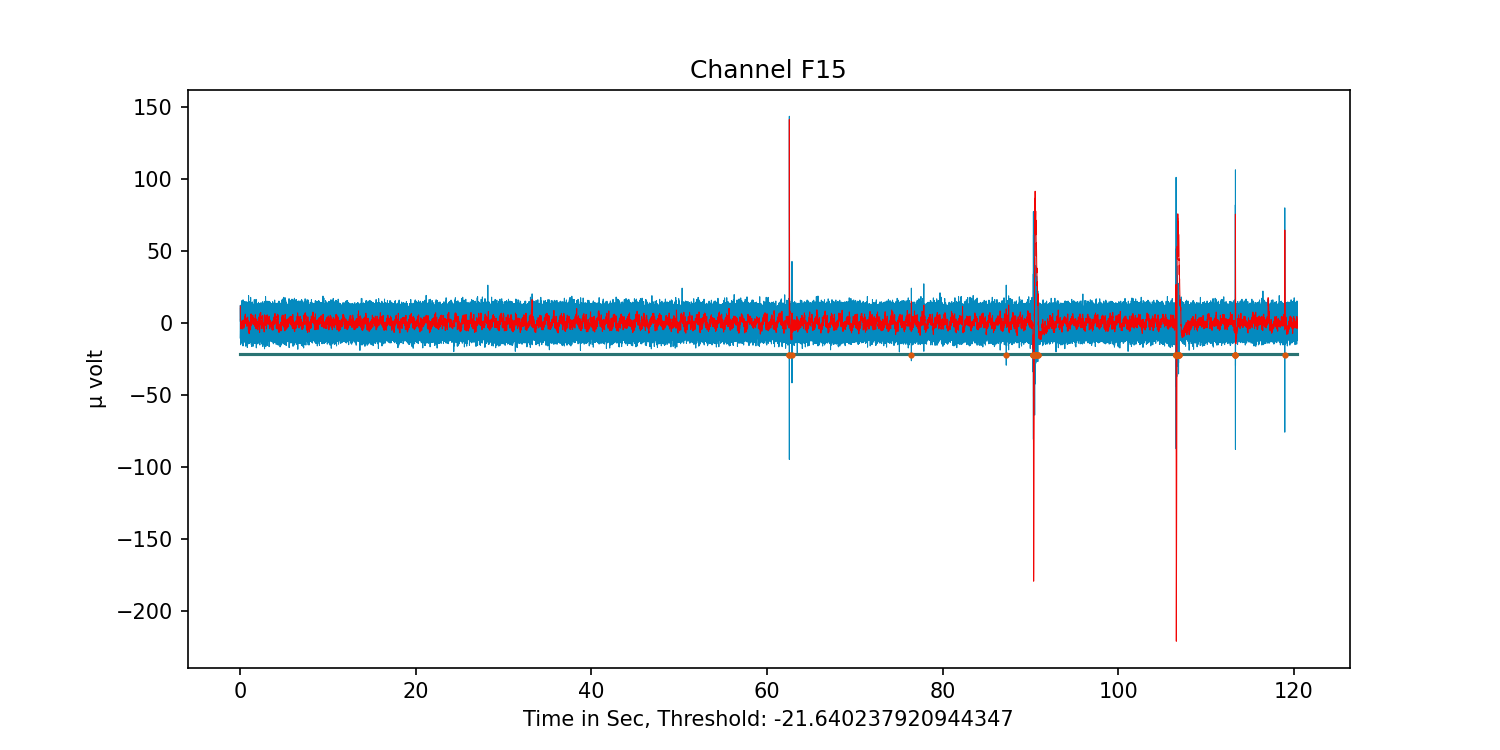

<ipython-input-31-3d89a1c96259>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [threshold, threshold], c="#297373")
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec, Threshold: %s' %threshold)
ax = plt.ylabel('µ volt')

fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP.png')

In [32]:
len(butter_lowpass_filtered_signal)

3010000

In [38]:
# we want to find where the lfp passes a mean threshold

lfp_mean = np.mean(butter_lowpass_filtered_signal)
lfp_std = np.std(butter_lowpass_filtered_signal)

In [34]:
lfp_mean, lfp_std

(-0.03363066400647817, 7.731779673635223)

In [36]:
def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold):

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] < -lfp_threshold:
                stop = i
                i += 1
            lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] > lfp_threshold:
                stop = i
                i += 1
            lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
            
    return lfp_down_crossing, lfp_up_crossing
            
            
    

In [ ]:
def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

In [ ]:
def get_next_maximum(signal, index, max_samples_to_search):
    """
    Returns the index of the next maximum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    max_idx = np.argmax(signal[index:search_end_idx])
    return index + max_idx

In [ ]:
def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold):

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    amplitudes_up = []
    amplitudes_down = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] < -lfp_threshold:
                stop = i
                i += 1
            lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            amplitude_point = get_next_minimum(lowpass_filtered_signal, start, stop-start)
            amplitude_down = lowpass_filtered_signal[amplitude_point]
            amplitudes_down.append(amplitude_down)
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while lowpass_filtered_signal[i] > lfp_threshold:
                stop = i
                i += 1
            lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            amplitude_point = get_next_maximum(lowpass_filtered_signal, start, stop-start)
            amplitude_up = lowpass_filtered_signal[amplitude_point]
            amplitudes_up.append(amplitude_up)
            
            
    return lfp_down_crossing, lfp_up_crossing, amplitudes_down, amplitudes_up
            

In [44]:
down_cross, up_cross, amp_down, amp_up = lfp_crossing_detection(butter_lowpass_filtered_signal, (3*lfp_std))

In [46]:
len(down_cross)

167

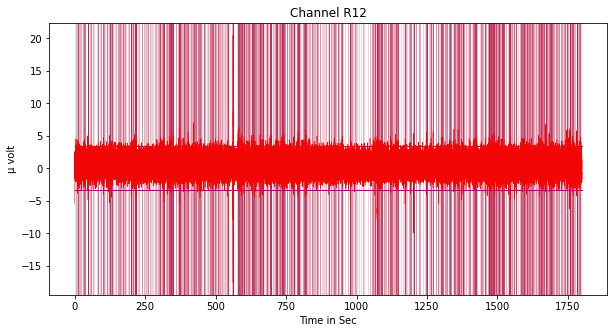

In [51]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.1)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
#ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [3*lfp_std, 3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-3*lfp_std, -3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

<IPython.core.display.Javascript object>


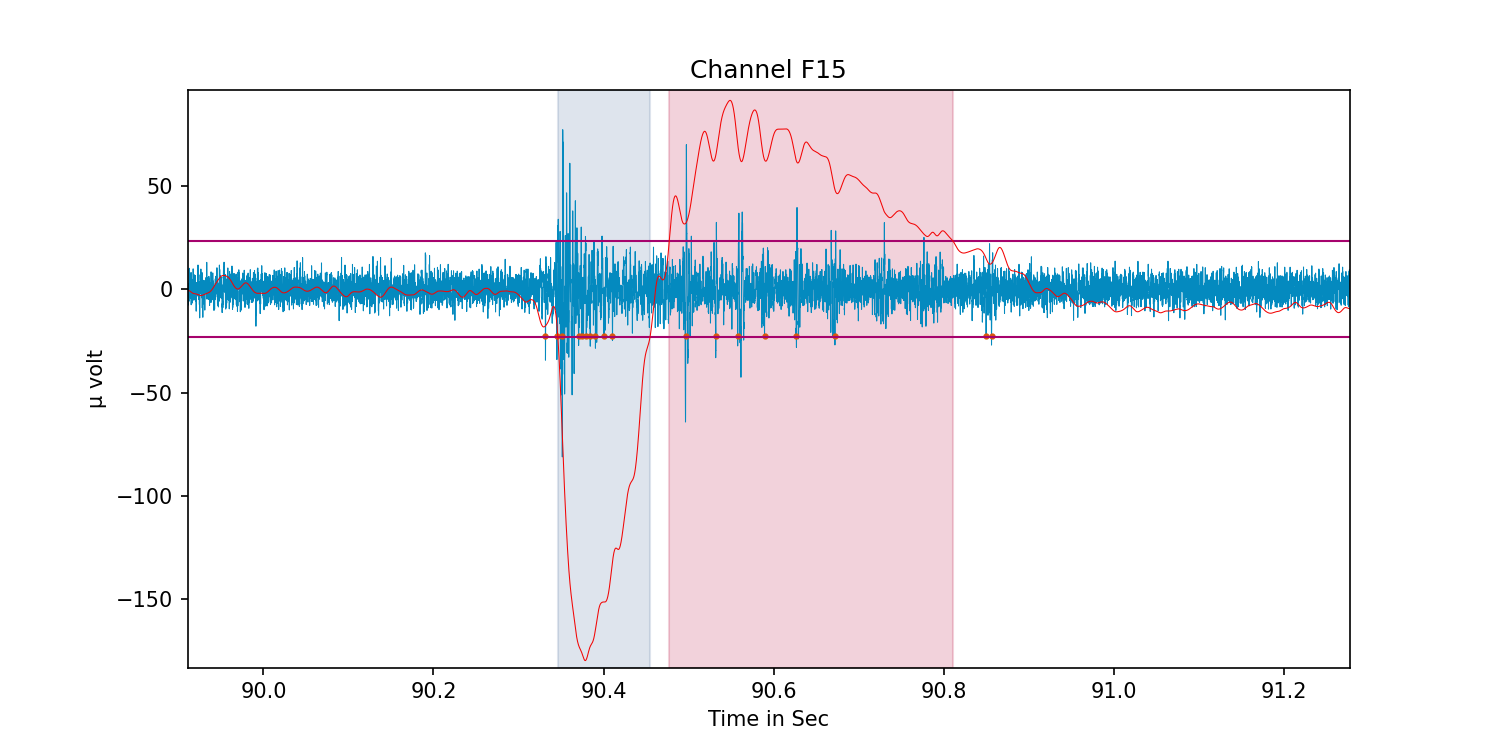

<ipython-input-40-57b809aced11>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [40]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [3*lfp_std, 3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-3*lfp_std, -3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

In [ ]:
# for every channel in our lowpass_dictionary, we want the std*3 for threshold

lowpass_threshold_dic = {}
up_crossing_dic = {}
down_crossing_dic = {}
amplitudes_up = {}
amplitudes_down = {}

for key in lowpass_dic:
    std = np.std(lowpass_dic[key][0])
    lowpass_threshold_dic[key] = std*3
    

# we want the up crossings of the lfp
# and the donwcrossings of the lfp

for key in lowpass_dic:
    
    threshold = lowpass_threshold_dic[key]
    low_signal = lowpass_dic[key][0]
    
    down_cross, up_cross, amp_down, amp_up = lfp_crossing_detection(
        low_signal, threshold)
    
    up_crossing_dic[key] = up_cross
    down_crossing_dic[key] = down_cross
    amplitudes_up[key] = amp_up
    amplitueds_down[key] = amp_down
    

In [192]:
interesting_LFP = ['J2', 'J3', 'K2', 'K3', 'J13', 'J14', 'K13', 'K14', 'F15', 'E15']

<IPython.core.display.Javascript object>


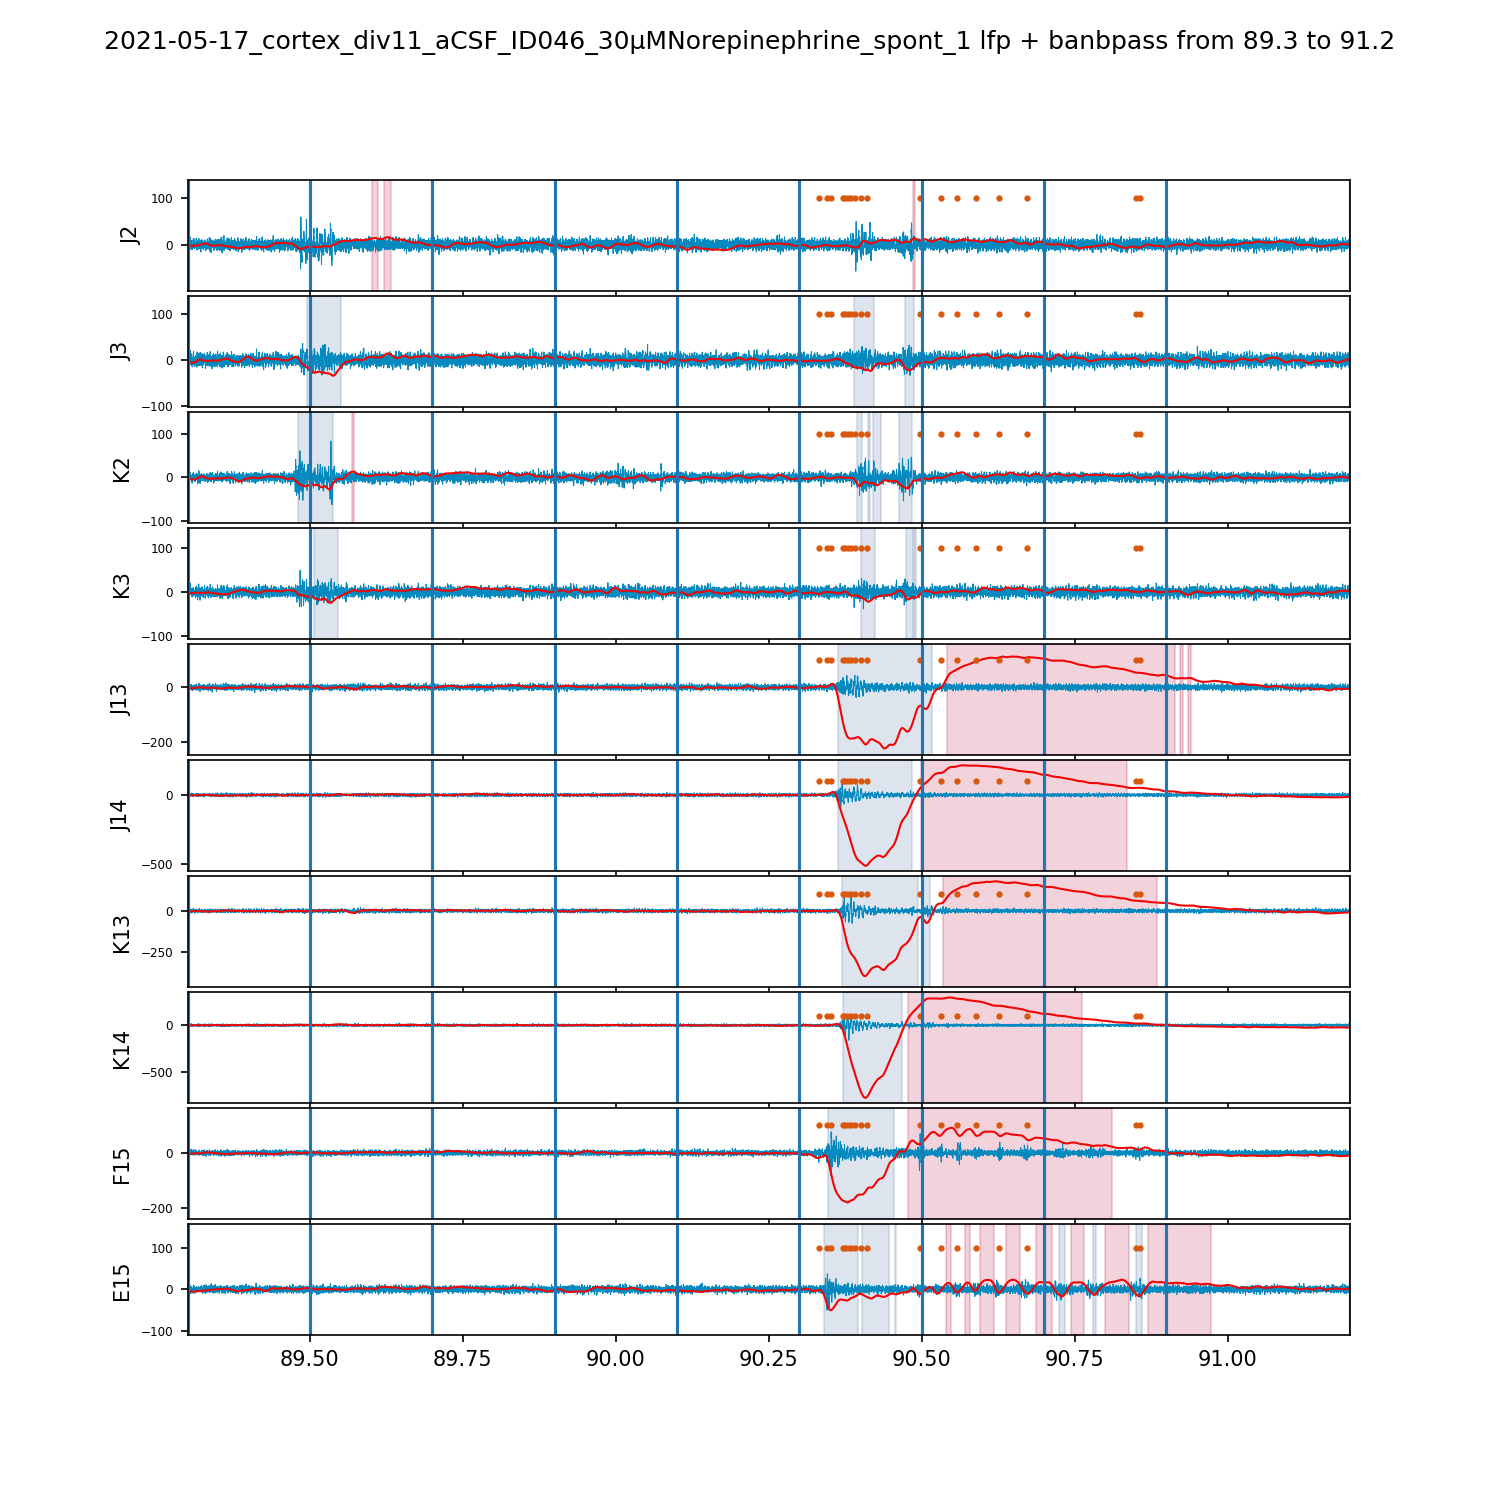

<ipython-input-197-50d5fa4757aa>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[-1] = plt.plot(spikes*tick*scale_factor_for_second,
<ipython-input-197-50d5fa4757aa>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[-1] = plt.plot(spikes*tick*scale_factor_for_second,
<ipython-input-197-50d5fa4757aa>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[-1] = plt.plot(spikes*tick*scale_factor_for_second,
<ipython-input-197-50d5fa4757aa>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[-1] = plt.plot(spikes*tick*scale_factor_for_

In [197]:
fig = plt.figure(figsize=(10,10))
limit0 = 89.3
limit1 = 91.2


windowsize = 0.2 #in seconds
win = limit0
windows = []
while win < limit1:
    if win + windowsize >= limit1:
        win = limit1
        windows.append(win)
    else:
        windows.append(win)
        win += windowsize

number_interesting_LFP = len(interesting_LFP)
#fig.tight_layout()
gs1 = gridspec.GridSpec(number_interesting_LFP, 1)
gs1.update(wspace=0.025, hspace=0.05) 
axs = []

for i in range(1, len(interesting_LFP)+1):
    
    # get the key of the channel
    key = interesting_LFP[i-1]
    
    #no get all signals to plot and the lfp_down and lfp_ups
    bandpass_signal = bandpass_dic[key]
    # in the lowpass_dic there are still additional returns from the old butter filter function
    lowpass_signal = lowpass_dic[key][0]
    lfp_ups = up_crossing_dic[key]
    lfp_downs = down_crossing_dic[key]
    
    
    axs.append(fig.add_subplot(gs1[i-1]))
    
    
    axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
    axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
    
    # spikes may be added additionally
    #axs[-1] = plt.plot(spikes*tick*scale_factor_for_second, 
     #                  [100]*(spikes*tick*scale_factor_for_second).shape[0], 
      #                 'ro', ms=2, c="#D9580D")

    
    for i in lfp_downs:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in lfp_ups:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
    for i in windows:
        ax = plt.axvline(i)
    
    # plt xlim for zooming in the time
    plt.xlim(limit0, limit1)    
    plt.yticks(fontsize='xx-small')
    plt.ylabel(key)
    #plt.ylim(-100, 100)
    

fig.suptitle(filebase + ' lfp + banbpass from '+str(limit0)+' to '+str(limit1))
fig.savefig(
    filebase + '_lfp_and_bandpasssignal_cutout_from_' + str(limit0) +'_to_'+str(limit1)+'.png',
    bbox_inches='tight', dpi=300)

In [195]:
spikes

array([1563659, 1563813, 1571219, 1911199, 2181412, 2258293, 2258629,
       2258788, 2259267, 2259367, 2259493, 2259610, 2259762, 2260014,
       2260263, 2262410, 2263298, 2263944, 2264733, 2265672, 2266803,
       2271248, 2271407, 2664734, 2665071, 2665283, 2665420, 2665626,
       2665726, 2665889, 2666044, 2666186, 2666606, 2667118, 2667254,
       2667524, 2668113, 2669111, 2669587, 2670870, 2672165, 2673329,
       2834014, 2834241, 2834367, 2974797], dtype=int64)

In [104]:
lowpass_signal

(array([5.68900865, 5.66306546, 5.63711961, ..., 1.78719673, 1.78716393,
        1.78713201]),
 array([3.91302054e-05, 7.82604108e-05, 3.91302054e-05]),
 array([ 1.        , -1.98222893,  0.98238545]))

In [87]:
bandpass_dic

{'G13': array([0.15240587, 0.98626915, 2.85086618, ..., 4.41586878, 6.29010552,
        8.28649551]),
 'G12': array([ 0.64948349,  3.45910291,  7.87847738, ..., -1.65921053,
        -2.68900204, -1.96463   ]),
 'F16': array([0.20867881, 1.11628415, 2.44812598, ..., 2.22131436, 2.74884864,
        4.74255338]),
 'F15': array([ 0.81126818,  4.26813203,  9.56608197, ..., -6.68994557,
        -4.40205936, -1.73453422]),
 'F14': array([ 0.29777763,  1.54977308,  3.31574514, ..., -1.0963439 ,
        -1.03260022, -1.08972174]),
 'F13': array([0.1617847 , 0.98722675, 2.6202342 , ..., 1.36133291, 0.58687532,
        0.21216949]),
 'F12': array([ 0.88395406,  4.62491457, 10.20126516, ..., -2.62601538,
        -2.77000523, -3.05608211]),
 'E16': array([ 0.75968466,  3.86895467,  8.11199533, ..., -1.66490566,
        -3.49241667, -4.3414667 ]),
 'E15': array([ 0.1219247 ,  0.8377852 ,  2.53280444, ..., -0.23542396,
         1.13167213,  1.79729714]),
 'E14': array([ 0.08909882,  0.64216774,  2.26

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig('divided_burst_spatial_10082021_b25.png', dpi=300, bbox_inches = 'tight')

In [42]:
np.linspace(0, 2 * np.pi, num=100)

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [43]:
np.cos(np.linspace(0, 2 * np.pi, num = 100))

array([ 1.        ,  0.99798668,  0.99195481,  0.9819287 ,  0.9679487 ,
        0.95007112,  0.92836793,  0.90292654,  0.87384938,  0.84125353,
        0.80527026,  0.76604444,  0.72373404,  0.67850941,  0.63055267,
        0.58005691,  0.52722547,  0.47227107,  0.41541501,  0.35688622,
        0.29692038,  0.23575894,  0.17364818,  0.1108382 ,  0.04758192,
       -0.01586596, -0.07924996, -0.14231484, -0.20480667, -0.26647381,
       -0.32706796, -0.38634513, -0.44406661, -0.5       , -0.55392006,
       -0.60560969, -0.65486073, -0.70147489, -0.74526445, -0.78605309,
       -0.82367658, -0.85798341, -0.88883545, -0.91610846, -0.93969262,
       -0.95949297, -0.97542979, -0.98743889, -0.99547192, -0.99949654,
       -0.99949654, -0.99547192, -0.98743889, -0.97542979, -0.95949297,
       -0.93969262, -0.91610846, -0.88883545, -0.85798341, -0.82367658,
       -0.78605309, -0.74526445, -0.70147489, -0.65486073, -0.60560969,
       -0.55392006, -0.5       , -0.44406661, -0.38634513, -0.32

In [47]:
sig_neo = AnalogSignal(bandpassfilteredsignal, sampling_rate=25000*pq.Hz, units='mV')

In [48]:
sig_neo

AnalogSignal with 1 channels of length 3010000; units mV; datatype float64 
sampling rate: 25000.0 Hz
time: 0.0 s to 120.4 s

In [52]:
freq, psd = welch_psd(sig_neo)

In [53]:
freq, psd

(array([0.00000000e+00, 3.73754650e-02, 7.47509299e-02, ...,
        1.24999252e+04, 1.24999626e+04, 1.25000000e+04]) * Hz,
 array([[3.37487892e-08, 1.68743888e-08, 5.46382557e-22, ...,
         3.81985992e-32, 3.97097524e-32, 1.95987874e-32]]) * mV**2/Hz)

In [54]:
freq.shape

(334445,)

In [55]:
psd.shape

(1, 334445)

<IPython.core.display.Javascript object>


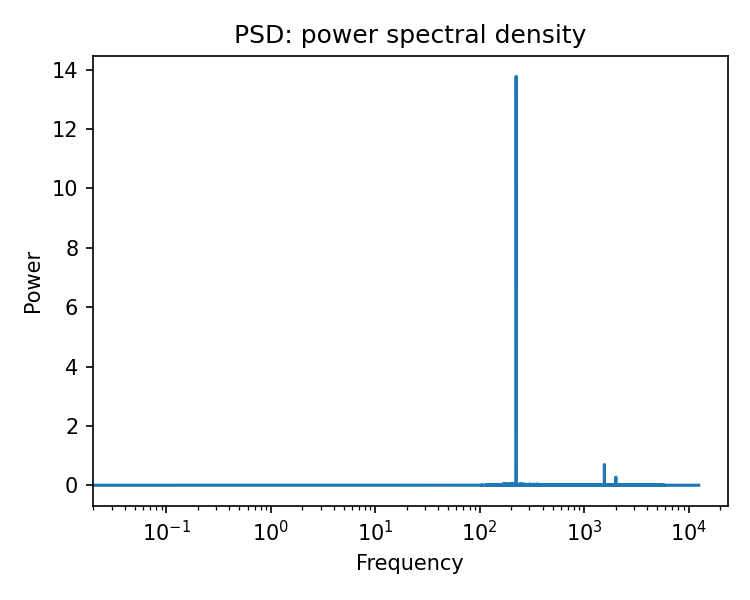

In [61]:


plt.figure(figsize=(5, 4))
plt.semilogx(freq, psd[0])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()